# Modèles de machine learning régression

## Objectifs de ce notebook

Dans ce notebook, nous allons tester différents modèles de machine learning pour la prédiction :

**Prédiction du nombre de jour depuis la date de sortie avant réduction (33%)**

Comparaison des performances de plusieurs modèles
- **Régression linéaire** 
- **Random forest**
- **XGBoost**

## Données utilisées

Utilisation du fichier nettoyé dataset jeux ps5 avec travail sur les features réalisé: **featured_games_dataset_final.csv**.

- modélisation avec les données de bases
- modélisation avec les données après feature engineering

## Note sur les librairies utilisées

Ce notebook utilise scikit learn pour la partie machine learning

## Import des librairies

In [87]:


# Python base
import sys
from pathlib import Path
import os

# Bibliothèques principales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder,OneHotEncoder,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    BayesianRidge,
    HuberRegressor,
    RANSACRegressor,
    Lars,
    LassoLars,
    OrthogonalMatchingPursuit,
)
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    ExtraTreesRegressor,
    HistGradientBoostingRegressor,
    BaggingRegressor,
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

## Méthodes utiles

In [88]:
def column_summary(df: pd.DataFrame):
    summary = []
    for col in df.columns:
        col_type = df[col].dtype
        non_null = df[col].notna().sum()
        null_count = df[col].isna().sum()
        
        # Gérer le cas où la colonne contient des listes (unhashable)
        try:
            unique_count = df[col].nunique()
        except TypeError:
            # Si erreur (listes), convertir en string temporairement
            unique_count = df[col].astype(str).nunique()
            print(f"⚠️ Colonne '{col}' contient des types non-hashable (probablement des listes)")

        summary.append({
            'Column': col,
            'Type': str(col_type),
            'Non-Null Count': non_null,
            'Null Count': null_count,
            'Unique Values': unique_count,
        })

    # Afficher le résumé des colonnes
    print("=" * 80)
    print("Résumé détaillé des colonnes:")
    print("=" * 80)
    column_summary_df = pd.DataFrame(summary)
    print(column_summary_df.to_string(index=False))
    print("\n")

In [89]:
class OutlierClipper(BaseEstimator, TransformerMixin):
    """Clip les outliers avec la méthode IQR"""
    
    def __init__(self):
        self.lower_bounds_ = None
        self.upper_bounds_ = None
    
    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X_values = X.values
        else:
            X_values = X
        
        Q1 = np.percentile(X_values, 25, axis=0)
        Q3 = np.percentile(X_values, 75, axis=0)
        IQR = Q3 - Q1
        
        self.lower_bounds_ = Q1 - 1.5 * IQR
        self.upper_bounds_ = Q3 + 1.5 * IQR
        
        return self
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X_values = X.values
            X_clipped = np.clip(X_values, self.lower_bounds_, self.upper_bounds_)
            return pd.DataFrame(X_clipped, columns=X.columns, index=X.index)
        else:
            return np.clip(X, self.lower_bounds_, self.upper_bounds_)

In [90]:
class ZeroImputer(BaseEstimator, TransformerMixin):
    """Impute les valeurs manquantes par 0"""
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X.fillna(0)
        else:
            # Si numpy array
            X_copy = X.copy()
            X_copy[np.isnan(X_copy)] = 0
            return X_copy

## Chargement des données

In [91]:
path = os.path.join(Path.cwd().parent, "data/processed")

In [92]:
# Charger les données CSV pour verifier
df_dataset = pd.read_csv(os.path.join(path, "featured_games_dataset_final.csv"))

In [93]:
column_summary(df_dataset)

Résumé détaillé des colonnes:
                              Column    Type  Non-Null Count  Null Count  Unique Values
                            id_store  object            5382           0           5382
               pssstore_stars_rating float64            5382           0            352
         pssstore_stars_rating_count   int64            5382           0           1583
             metacritic_critic_score float64            1268        4114             67
                              is_ps4   int64            5382           0              2
                            is_indie   int64            5382           0              2
                              is_dlc   int64            5382           0              1
                               is_vr   int64            5382           0              2
                     is_opti_ps5_pro   int64            5382           0              2
                         is_remaster   int64            5382           0              2
  

In [94]:
df_dataset.head()

,id_store,pssstore_stars_rating,pssstore_stars_rating_count,metacritic_critic_score,is_ps4,is_indie,is_dlc,is_vr,is_opti_ps5_pro,is_remaster,...,content_category,exclusif_playstation_content,visibility_score,visibility_category,pegi_unified,price_category,game_age_years,month_sin,month_cos,release_season
0,EP8311-PPSA19174_00-0421646910657705,1.57,14,NaN,0,0,0,0,0,0,...,minimal,0,7.0,obscure,7,0 - 7.99,2,-8.660254e-01,0.500000,fall
1,EP2005-PPSA06055_00-SINUCA0000000000,3.26,72,NaN,0,0,0,0,0,0,...,minimal,0,43.0,moderate,3,0 - 7.99,3,5.000000e-01,-0.866025,spring
2,EP8311-PPSA16513_00-0233078860249892,1.55,11,NaN,0,0,0,0,0,0,...,minimal,0,7.0,obscure,3,0 - 7.99,2,5.000000e-01,-0.866025,spring
3,EP8311-PPSA13840_00-0277389480637871,1.44,18,NaN,0,0,0,0,0,0,...,minimal,0,8.0,obscure,3,0 - 7.99,2,5.000000e-01,0.866025,winter
4,EP8311-PPSA12662_00-0212989199890961,1.17,23,NaN,0,0,0,0,0,0,...,minimal,0,8.0,obscure,3,0 - 7.99,3,-2.449294e-16,1.000000,winter


## Rappel des features disponibles

In [ ]:
# 47 features au total

# X Basic features simple sans traitement avancés (28)

# base_price                    - numeric (float)
# pssstore_stars_rating_count   - numeric (int)
# pssstore_stars_rating         - numeric (float)
# is_indie                      - boolean
# has_microtransactions         - boolean
# dlcs_count                        - numeric (int)
# packs_deluxe_count            - numeric (int)
# series_count                   - numeric (int)
# trophies_count                - numeric (int)
# is_vr                         - boolean
# has_local_multiplayer         - boolean
# has_online_multiplayer        - boolean
# is_online_only                - boolean
# is_opti_ps5_pro               - boolean
# is_ps_exclusive               - boolean
# difficulty                    - numeric (int)
# is_remaster                   - boolean
# is_ps4                        - boolean
# pegi_unified                  - category (numeric)
# metacritic_critic_score       - numeric (float)
# hours_main_story              - numeric (float)
# voice_languages_count        - numeric (int)
# sub_languages_count           - numeric (int)
# download_size_gb              - numeric (float)
# price_category                - category



#  X Advanced features engineered (19)

# popularity_score              - numeric (float)
# popularity_category           - category
# visibility_score              - numeric (float)
# visibility_category           - category
# exclusif_playstation_content  - boolean
# publisher_game_count          - numeric (int)
# publisher_game_count_cat      - category
# publisher_category            - category
# genre_action_aventure         - boolean
# genre_roles                   - boolean
# genre_sports                  - boolean
# genre_reflexion               - boolean
# genre_rapide                  - boolean
# localization_category         - category
# download_size_category        - category
# content_score                 - numeric (float)
# content_category              - category
# game_age_years                - numeric (int)
# release_season                - category


#  X Bonus observations à + 60 jours (2)

# has_5pct_discount_at_30d      - boolean
# has_10pct_discount_at_60d     - boolean

# Y
# 
# Regression nombre de jours
# 
# days_to_10_percent_discount - numeric (int)
# days_to_25_percent_discount - numeric (int)
# days_to_33_percent_discount - numeric (int)
# days_to_50_percent_discount - numeric (int)
# days_to_75_percent_discount - numeric (int)

# Classification tranche délais avant promotion
# 
# days_to_10_percent_discount_category - category
# days_to_25_percent_discount_category - category
# days_to_33_percent_discount_category - category
# days_to_50_percent_discount_category - category
# days_to_75_percent_discount_category - category

## Combinaison de features

In [ ]:
# Feature de base sans feature engeniering avancés
base_features = {
    "numeric_continuous": [
        "base_price",
        "hours_main_story",
        "download_size_gb",
    ],
    "numeric_discrete_zero": [
        "packs_deluxe_count",
        "series_count",
        "sub_languages_count",
        "voice_languages_count",
        "dlcs_count",
        "game_age_years",
        "release_month",
    ],
    "numeric_discrete_median": [
        "trophies_count",
    ],
    "boolean_cols": [
        "is_indie",
        "is_vr",
        "is_ps_exclusive",
        "is_remaster",
        "is_ps4",
        "has_local_multiplayer",
        "has_online_multiplayer",
        "is_online_only",
        "has_microtransactions",
        "is_opti_ps5_pro",
        "genre_action_aventure",
        "genre_roles",
        "genre_sports",
        "genre_reflexion",
        "genre_rapide",
    ],
    "categorical_cols": [
        "release_season",
    ],
    "ordinal_cols": ["difficulty", "pegi_unified"],
    "passthrough_cols": ["month_sin", "month_cos"],
}

# Feature de base sans feature engeniering avancés + données disponible + 60j après sortie
base_features_post_release = {
    "numeric_continuous": [
        "base_price",
        "hours_main_story",
        "download_size_gb",
        "pssstore_stars_rating",  # Observation post sortie
        "metacritic_critic_score",  # Observation post sortie
    ],
    "numeric_discrete_zero": [
        "packs_deluxe_count",
        "series_count",
        "sub_languages_count",
        "voice_languages_count",
        "dlcs_count",
        "game_age_years",
        "release_month",
    ],
    "numeric_discrete_median": [
        "trophies_count",
        "pssstore_stars_rating_count",  # Observation post sortie
    ],
    "boolean_cols": [
        "is_indie",
        "is_vr",
        "is_ps_exclusive",
        "is_remaster",
        "is_ps4",
        "has_local_multiplayer",
        "has_online_multiplayer",
        "is_online_only",
        "has_microtransactions",
        "is_opti_ps5_pro",
        "genre_action_aventure",
        "genre_roles",
        "genre_sports",
        "genre_reflexion",
        "genre_rapide",
        "has_5pct_discount_at_30d",  # Observation post sortie
        "has_10pct_discount_at_60d",  # Observation post sortie
    ],
    "categorical_cols": [
        "release_season",
    ],
    "ordinal_cols": ["difficulty", "pegi_unified"],
    "passthrough_cols": ["month_sin", "month_cos"],
}

# Feature de base + Feature engeniering avancés
all_features = {
    "numeric_continuous": [
        "base_price",
        "hours_main_story",
        "download_size_gb",
    ],
    "numeric_discrete_zero": [
        "packs_deluxe_count",
        "series_count",
        "sub_languages_count",
        "voice_languages_count",
        "publisher_game_count",
        "dlcs_count",
        "game_age_years",
        "release_month",
    ],
    "numeric_discrete_median": [
        "trophies_count",
    ],
    "boolean_cols": [
        "is_indie",
        "is_vr",
        "is_ps_exclusive",
        "is_remaster",
        "is_ps4",
        "has_local_multiplayer",
        "has_online_multiplayer",
        "is_online_only",
        "has_microtransactions",
        "is_opti_ps5_pro",
        "exclusif_playstation_content", #advanced
        "genre_action_aventure",
        "genre_roles",
        "genre_sports",
        "genre_reflexion",
        "genre_rapide",
    ],
    "categorical_cols": [
        "price_category",
        "publisher_category",
        "visibility_category", # advanced
        "content_category", # advanced
        "download_size_category",
        "localization_category",
        "publisher_game_count_cat",
        "release_season",
    ],
    "ordinal_cols": ["difficulty", "pegi_unified"],
    "score_cols": ["visibility_score", "content_score"], #advanced
    "passthrough_cols": ["month_sin", "month_cos"],
}

# Feature de base + Feature engeniering avancés + données disponible 60j après sortie
all_features_post_release = {
    "numeric_continuous": [
        "base_price",
        "pssstore_stars_rating",  # Observation post sortie
        "metacritic_critic_score",  # Observation post sortie
        "hours_main_story",
        "download_size_gb",
    ],
    "numeric_discrete_zero": [
        "packs_deluxe_count",
        "series_count",
        "sub_languages_count",
        "voice_languages_count",
        "publisher_game_count",
        "dlcs_count",
        "game_age_years",
        "release_month",
    ],
    "numeric_discrete_median": [
        "pssstore_stars_rating_count",  # Observation post sortie
        "trophies_count",
    ],
    "boolean_cols": [
        "is_indie",
        "is_vr",
        "is_ps_exclusive",
        "is_remaster",
        "is_ps4",
        "has_local_multiplayer",
        "has_online_multiplayer",
        "is_online_only",
        "has_microtransactions",
        "is_opti_ps5_pro",
        "exclusif_playstation_content", #advanced
        "has_5pct_discount_at_30d",  # Observation post sortie
        "has_10pct_discount_at_60d",  # Observation post sortie
        "genre_action_aventure",
        "genre_roles",
        "genre_sports",
        "genre_reflexion",
        "genre_rapide",
    ],
    "categorical_cols": [
        "price_category",
        "publisher_category",
        "visibility_category", # advanced
        "popularity_category",  # Observation post sortie
        "content_category", # advanced
        "download_size_category",
        "localization_category",
        "publisher_game_count_cat",
        "release_season",
    ],
    "ordinal_cols": ["difficulty", "pegi_unified"],
    "score_cols": ["popularity_score", "visibility_score", "content_score"], #advanced
    "passthrough_cols": ["month_sin", "month_cos"],
}

In [97]:
def get_all_features_columns(features_dict):
    all_columns = []
    for feature_list in features_dict.values():
        all_columns.extend(feature_list)
    return all_columns

### En attente de tests

In [98]:
# pssstore_stars_rating_count (0 à 1.8M) → log transform pour réduire l'échelle

## Preprocessing

1. Numériques continues → Imputation + Scaling (si nécessaire)
2. Numériques discrètes → Imputation + Binning ou Sqrt (optionnel)
3. Booléennes → Format 0/1
4. Ordinales → Garder l'ordre naturel
5. Nominales → Label Encoding (Modèles Arbres)

### Pipeline preprocessing sci kit learn

In [99]:
def create_pipeline(model_type: str, available_columns: dict):
    """
    Crée un Pipeline sklearn pour le preprocessing, Type de modèle : 'tree', 'linear', 'svm'
        X_train_processed = pipeline.fit_transform(X_train)
        X_test_processed = pipeline.transform(X_test)
    """

    print(f"Création du pipeline pour modèle : {model_type.upper()}")

    # Liste pour stocker tous les transformers
    transformers = []

    # NUMÉRIQUES CONTINUES
    filtered_numeric_continuous = available_columns.get("numeric_continuous", [])

    if model_type == "tree":
        # TREE: Juste imputation, pas de scaling
        numeric_continuous_transformer = Pipeline(
            steps=[("imputer", SimpleImputer(strategy="median"))]
        )

    elif model_type == "linear":
        # LINEAR: Imputation + Outliers + Standardisation
        numeric_continuous_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("outlier_clipper", OutlierClipper()),
                ("scaler", StandardScaler()),
            ]
        )

    elif model_type == "svm":
        # SVM: Imputation + Outliers + Normalisation [0,1]
        numeric_continuous_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("outlier_clipper", OutlierClipper()),
                ("scaler", MinMaxScaler()),
            ]
        )

    if filtered_numeric_continuous is not None and len(filtered_numeric_continuous) > 0:
        transformers.append(
            (
                "num_continuous",
                numeric_continuous_transformer,
                filtered_numeric_continuous,
            )
        )

    # NUMERIQUES DISCRETES zéro
    numeric_discrete_zero = available_columns.get("numeric_discrete_zero", [])

    if model_type == "tree":
        numeric_discrete_zero_transformer = Pipeline(
            steps=[("zero_imputer", ZeroImputer())]
        )
    elif model_type == "linear":
        numeric_discrete_zero_transformer = Pipeline(
            steps=[("zero_imputer", ZeroImputer()), ("scaler", StandardScaler())]
        )
    elif model_type == "svm":
        numeric_discrete_zero_transformer = Pipeline(
            steps=[("zero_imputer", ZeroImputer()), ("scaler", MinMaxScaler())]
        )

    if numeric_discrete_zero is not None and len(numeric_discrete_zero) > 0:
        transformers.append(
            (
                "num_discrete_zero",
                numeric_discrete_zero_transformer,
                numeric_discrete_zero,
            )
        )

    # NUMERIQUES DISCRETES médiane
    numeric_discrete_median = available_columns.get("numeric_discrete_median", [])

    if model_type == "tree":
        numeric_discrete_median_transformer = Pipeline(
            steps=[("imputer", SimpleImputer(strategy="median"))]
        )
    elif model_type == "linear":
        numeric_discrete_median_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler()),
            ]
        )
    elif model_type == "svm":
        numeric_discrete_median_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", MinMaxScaler()),
            ]
        )

    if numeric_discrete_median is not None and len(numeric_discrete_median) > 0:
        transformers.append(
            (
                "num_discrete_median",
                numeric_discrete_median_transformer,
                numeric_discrete_median,
            )
        )

    # BOOLÉENNES
    boolean_cols = available_columns.get("boolean_cols", [])
    boolean_transformer = Pipeline(
        steps=[("zero_imputer", ZeroImputer())]  # Remplacer NA par 0
    )

    if boolean_cols is not None and len(boolean_cols) > 0:
        transformers.append(("boolean", boolean_transformer, boolean_cols))

    # CATÉGORIELLES
    categorical_cols = available_columns.get("categorical_cols", [])

    if model_type == "tree":
        # TREE Label Encoding (via OrdinalEncoder)
        categorical_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
                (
                    "encoder",
                    OrdinalEncoder(
                        handle_unknown="use_encoded_value",
                        unknown_value=-1,
                        encoded_missing_value=-1,
                    ),
                ),
            ]
        )
    else:
        # LINEAR / SVM: One-Hot Encoding
        categorical_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
                (
                    "encoder",
                    OneHotEncoder(
                        drop="first", sparse_output=False, handle_unknown="ignore"
                    ),
                ),
            ]
        )

    if categorical_cols is not None and len(categorical_cols) > 0:
        transformers.append(("categorical", categorical_transformer, categorical_cols))

    # ORDINALES
    ordinal_cols = available_columns.get("ordinal_cols", [])

    if model_type == "tree":
        ordinal_transformer = Pipeline(
            steps=[("imputer", SimpleImputer(strategy="median"))]
        )
    else:  # linear ou svm
        ordinal_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler()),
            ]
        )

    if len(ordinal_cols) > 0:
        transformers.append(("ordinal", ordinal_transformer, ordinal_cols))

    # SCORES ENGINEERED
    score_cols = available_columns.get("score_cols", [])

    score_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),  # Recommandé pour tous les modèles
        ]
    )

    if score_cols is not None and len(score_cols) > 0:
        transformers.append(("scores", score_transformer, score_cols))

    # Colonnes Déjà normalisées, juste passer tel quel
    pass_cols = available_columns.get("passthrough_cols", [])
    pass_transformer = "passthrough"

    if pass_cols is not None and len(pass_cols) > 0:
        transformers.append(("pass", pass_transformer, pass_cols))

    # PIPELINE FINAL
    pipeline = Pipeline(
        steps=[
            (
                "preprocessor",
                ColumnTransformer(
                    transformers=transformers,
                    remainder="drop",  # Supprimer les colonnes non spécifiées
                    verbose_feature_names_out=False,  # Garder noms courts
                ),
            )
        ]
    )

    print(f"✅ Pipeline créé avec {len(transformers)} groupes de transformers")

    return pipeline

In [100]:
def save_pipeline(pipeline, filepath):
    """
    Sauvegarde le pipeline
    """
    import joblib
    joblib.dump(pipeline, filepath)
    print(f"✅ Pipeline sauvegardé : {filepath}")

In [101]:
def load_pipeline(filepath):
    """
    Charge un pipeline sauvegardé
    """
    import joblib
    pipeline = joblib.load(filepath)
    print(f"✅ Pipeline chargé : {filepath}")
    return pipeline

## Premier tests de prédictions

In [102]:
df_clean = df_dataset.copy()

### Choisir la target: niveau de promotion

In [103]:
TARGET_PROMO_COL = 'days_to_33_percent_discount'
FEATURES_TO_USE = all_features_post_release

### Nettoyage des données qui ne possèdent pas la target

In [104]:
# On supprime les lignes qui n'ont pas de target
df_clean = df_clean[df_clean[TARGET_PROMO_COL].notna()].copy()

print(f"Avant: {len(df_dataset)} lignes")
print(f"Après: {len(df_clean)} lignes")

Avant: 5382 lignes
Après: 3714 lignes


### Récupération des features de base

In [105]:
base_X_features = get_all_features_columns(FEATURES_TO_USE)

# Sélectionner colonnes disponibles
X = df_clean[base_X_features]

# On assigne la target
y = df_clean[TARGET_PROMO_COL]

### Vérification des colonnes 

In [106]:
column_summary(X)

Résumé détaillé des colonnes:
                      Column    Type  Non-Null Count  Null Count  Unique Values
                  base_price float64            3714           0             62
       pssstore_stars_rating float64            3714           0            331
     metacritic_critic_score float64            1038        2676             66
            hours_main_story float64            2486        1228             85
            download_size_gb float64            2017        1697            802
          packs_deluxe_count   int64            3714           0              9
                series_count   int64            3714           0             24
         sub_languages_count float64            2821         893             30
       voice_languages_count float64            1894        1820             17
        publisher_game_count   int64            3714           0             51
                  dlcs_count   int64            3714           0             54
          

### Création train test split

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTrain : {len(X_train)} | Test : {len(X_test)}")


Train : 2971 | Test : 743


### Creation des pipelines preprocess

In [108]:
def create_pipelines(X_train, X_test,available_columns: dict):
    pipeline_types = ['tree', 'linear', 'svm']
    pipelines = {}
    X_train_processed = {}
    X_test_processed = {}

    for t in pipeline_types:
        # Créer pipeline
        pipelines[t] = create_pipeline(model_type=t, available_columns=available_columns)
        
        # Fit et transform
        X_train_processed[t] = pipelines[t].fit_transform(X_train)
        X_test_processed[t] = pipelines[t].transform(X_test)

    return pipelines, X_train_processed, X_test_processed

In [109]:
pipelines, X_train_dict, X_test_dict = create_pipelines(X_train, X_test,available_columns=FEATURES_TO_USE)

for t, pipeline in pipelines.items():
    print(f"\n{t.upper()} Train processed : {X_train_dict[t].shape}")
    print(f"{t.upper()} Test processed  : {X_test_dict[t].shape}")

Création du pipeline pour modèle : TREE
✅ Pipeline créé avec 8 groupes de transformers
Création du pipeline pour modèle : LINEAR
✅ Pipeline créé avec 8 groupes de transformers
Création du pipeline pour modèle : SVM
✅ Pipeline créé avec 8 groupes de transformers

TREE Train processed : (2971, 48)
TREE Test processed  : (743, 48)

LINEAR Train processed : (2971, 76)
LINEAR Test processed  : (743, 76)

SVM Train processed : (2971, 76)
SVM Test processed  : (743, 76)


### TODO : Afficher données preprocessed
### TODO : test avec target standard scaler

### Métriques d'évaluation

- MAE - Mean Absolute Error (moyenne des erreurs des résidus)
- R2 - Coefficient de détermination ("J'explique X% de la variance")
- RMSE - Root Mean Squared Error (pénalise gros écarts)

### Régression linéaire

In [110]:

rf = LinearRegression()
rf.fit(X_train_dict['linear'], y_train)

predictions = rf.predict(X_test_dict['linear'])

mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
rmse = root_mean_squared_error(y_test, predictions)

print(f"\nLinear regression RÉSULTATS:")
print(f"   MAE : {mae:.2f} jours")
print(f"   R2  : {r2:.4f}")
print(f"   RMSE  : {rmse:.2f} jours")


Linear regression RÉSULTATS:
   MAE : 99.79 jours
   R2  : 0.1777
   RMSE  : 137.27 jours


### Affichage des résultats

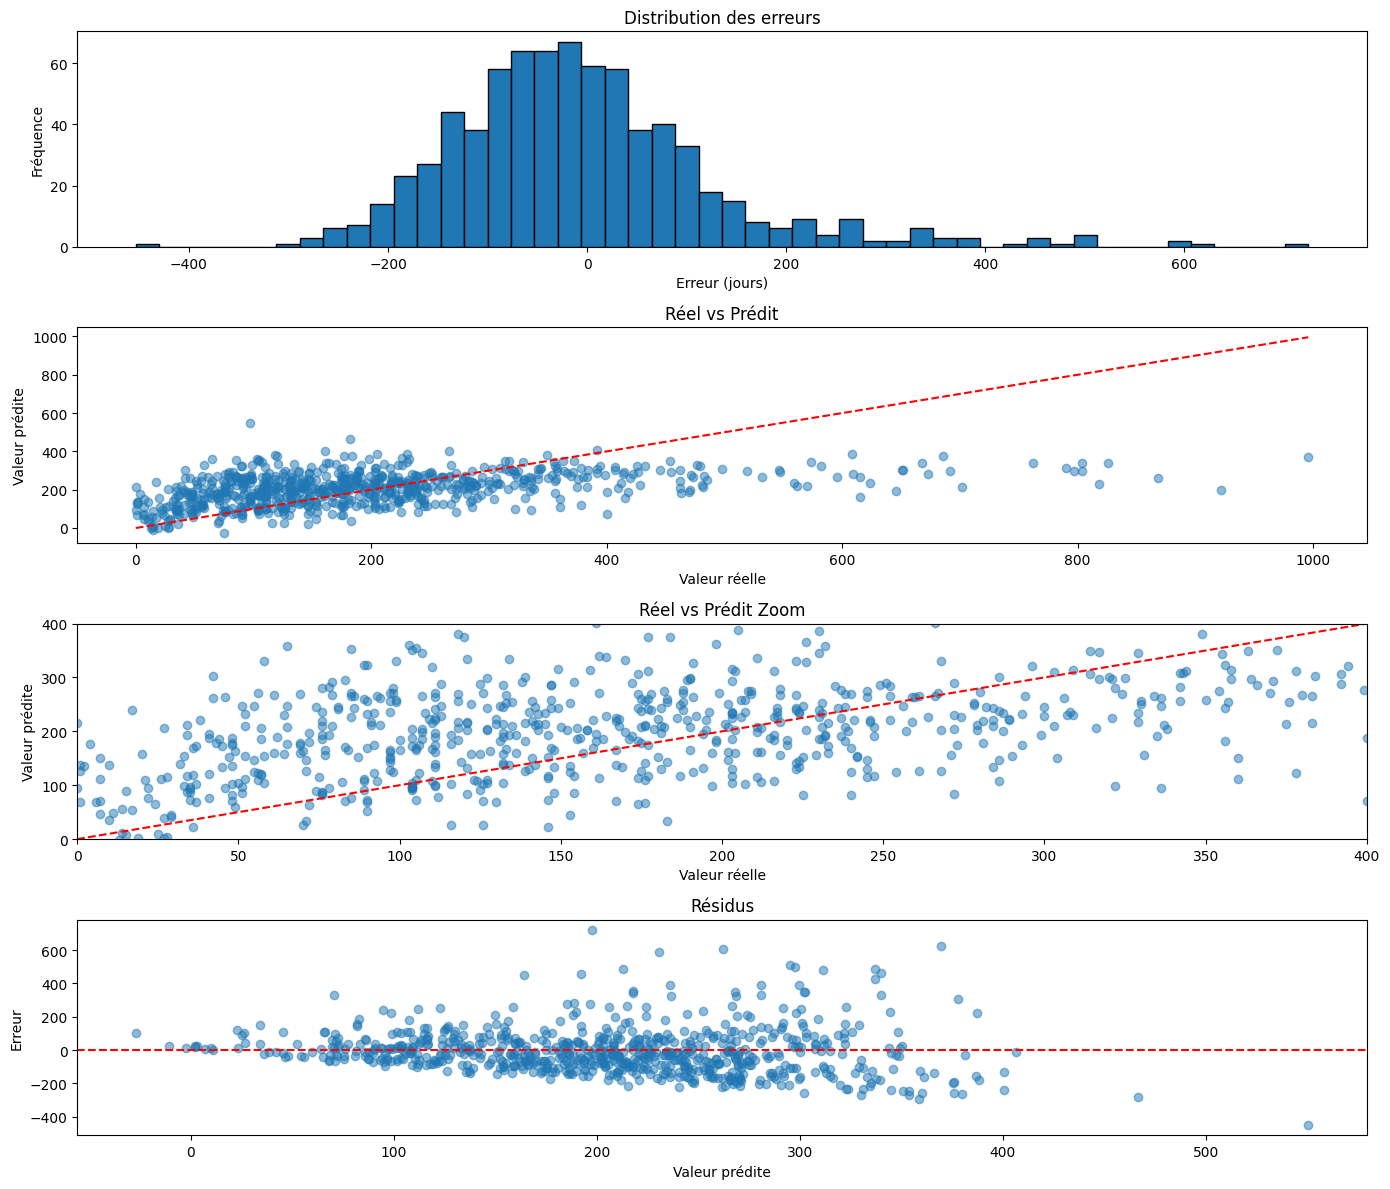

In [111]:
errors = y_test - predictions
fig, (ax1,ax2,ax22,ax3) = plt.subplots(4, 1, figsize=(14, 12))
ax1: plt.Axes
ax2: plt.Axes
ax22: plt.Axes
ax3: plt.Axes

ax1.hist(errors, bins=50, edgecolor='black')
ax1.set_xlabel('Erreur (jours)')
ax1.set_ylabel('Fréquence')
ax1.set_title('Distribution des erreurs')

ax2.scatter(y_test, predictions, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax2.set_xlabel('Valeur réelle')
ax2.set_ylabel('Valeur prédite')
ax2.set_title('Réel vs Prédit')

ax22.scatter(y_test, predictions, alpha=0.5)
ax22.plot([0, 400], [0, 400], 'r--')  # Ligne de référence ajustée
ax22.set_xlabel('Valeur réelle')
ax22.set_ylabel('Valeur prédite')
ax22.set_title('Réel vs Prédit Zoom')
ax22.set_xlim(0, 400)
ax22.set_ylim(0, 400)

ax3.scatter(predictions, errors, alpha=0.5)
ax3.axhline(0, color='red', linestyle='--')
ax3.set_xlabel('Valeur prédite')
ax3.set_ylabel('Erreur')
ax3.set_title('Résidus')

plt.tight_layout()
plt.show()

### Random forest

In [112]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train_dict['tree'], y_train)

predictions = rf.predict(X_test_dict['tree'])

mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
rmse = root_mean_squared_error(y_test, predictions)

print(f"\nRandomForestRegressor:")
print(f"   MAE : {mae:.2f} jours")
print(f"   R2  : {r2:.4f}")
print(f"   RMSE  : {rmse:.2f} jours")


RandomForestRegressor:
   MAE : 95.03 jours
   R2  : 0.2353
   RMSE  : 132.37 jours


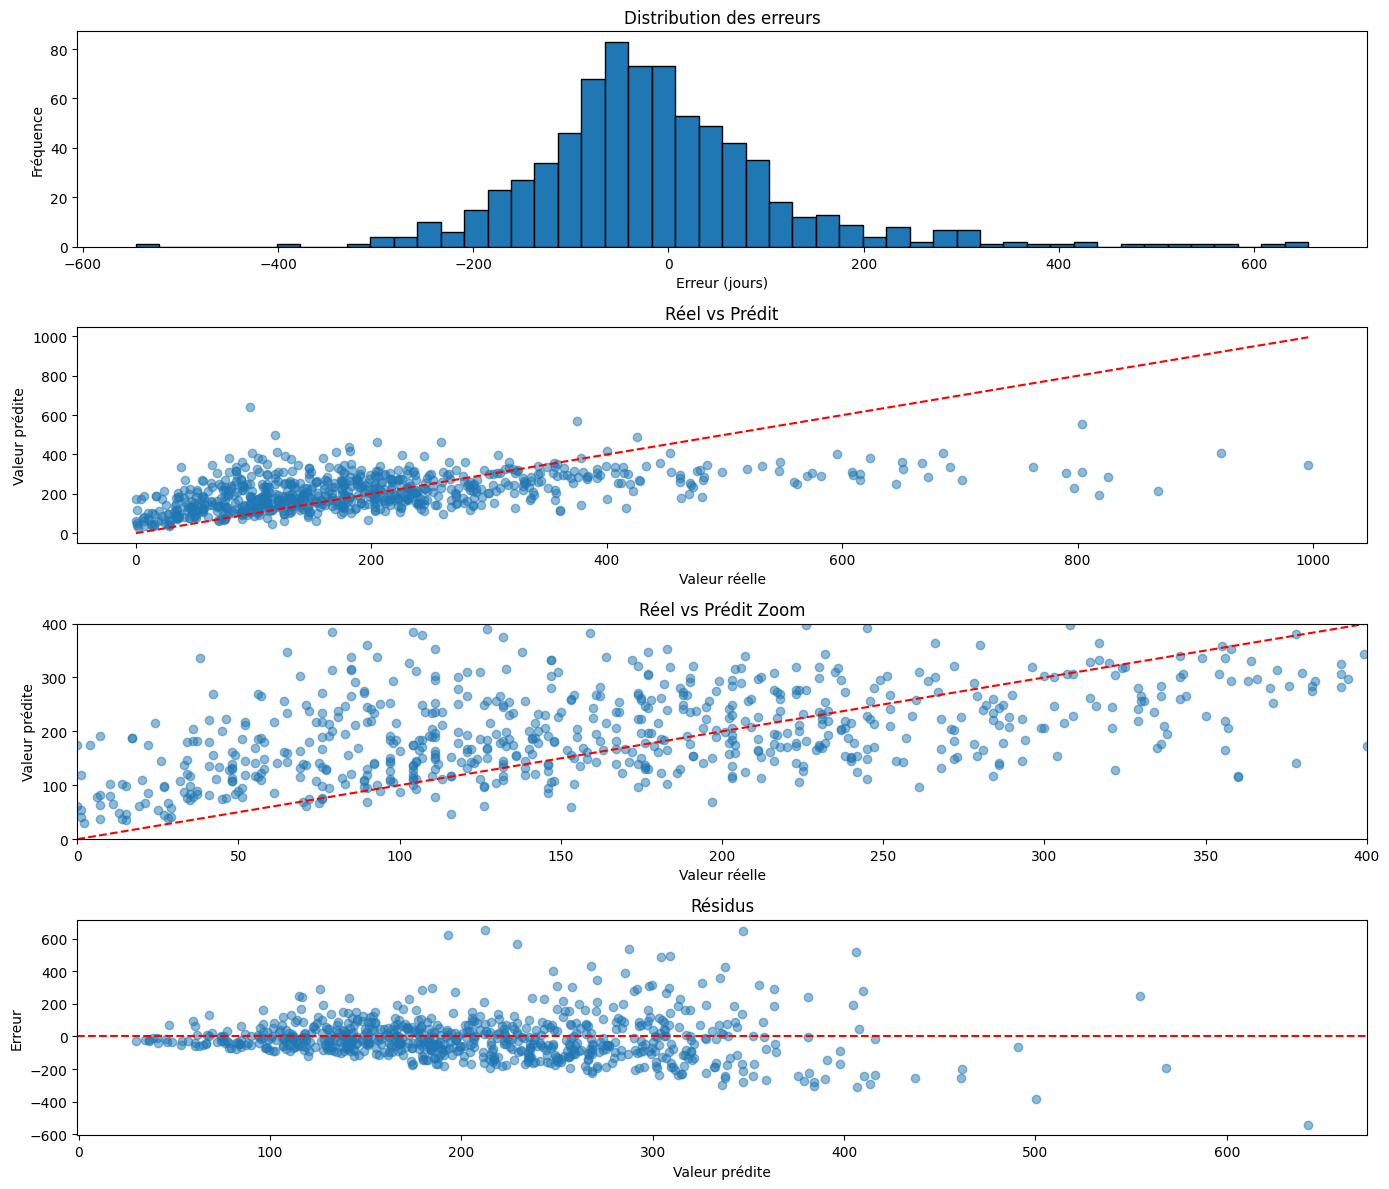

In [113]:
errors = y_test - predictions
fig, (ax1,ax2,ax22,ax3) = plt.subplots(4, 1, figsize=(14, 12))
ax1: plt.Axes
ax2: plt.Axes
ax22: plt.Axes
ax3: plt.Axes

ax1.hist(errors, bins=50, edgecolor='black')
ax1.set_xlabel('Erreur (jours)')
ax1.set_ylabel('Fréquence')
ax1.set_title('Distribution des erreurs')

ax2.scatter(y_test, predictions, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax2.set_xlabel('Valeur réelle')
ax2.set_ylabel('Valeur prédite')
ax2.set_title('Réel vs Prédit')

ax22.scatter(y_test, predictions, alpha=0.5)
ax22.plot([0, 400], [0, 400], 'r--')  # Ligne de référence ajustée
ax22.set_xlabel('Valeur réelle')
ax22.set_ylabel('Valeur prédite')
ax22.set_title('Réel vs Prédit Zoom')
ax22.set_xlim(0, 400)
ax22.set_ylim(0, 400)

ax3.scatter(predictions, errors, alpha=0.5)
ax3.axhline(0, color='red', linestyle='--')
ax3.set_xlabel('Valeur prédite')
ax3.set_ylabel('Erreur')
ax3.set_title('Résidus')

plt.tight_layout()
plt.show()

### Comparer les résultats

In [114]:
# générer plots de comparaison

## Automatiser démarche empirique

Création d'un système permettant de lancer une bibliothèque de modèles sur plusieurs combinaisons de features et plusieurs target de prédictions.

In [115]:
# Premièrer version de la liste généré par Claude code. Phase de vérification nécessaire.

regression_models = {
    # ========================================================================
    # MODÈLES LINÉAIRES (Rapides, interprétables)
    # ========================================================================
    "linear": [
        # --- Régression linéaire simple ---
        {
            "name": "Linear Regression",
            "category":"linear",
            "model": LinearRegression(),
            "description": "Régression linéaire classique (OLS)",
            "pros": "Simple, rapide, interprétable",
            "cons": "Sensible aux outliers et multicolinéarité",
            "best_for": "Baseline, relations linéaires simples",
        },
        # --- Ridge (L2 regularization) ---
        {
            "name": "Ridge",
            "category":"linear",
            "model": Ridge(alpha=1.0),
            "description": "Régression avec régularisation L2",
            "pros": "Gère la multicolinéarité, stable",
            "cons": "Ne fait pas de sélection de features",
            "best_for": "Features corrélées, éviter overfitting",
            "hyperparams": {"alpha": [0.1, 1.0, 10.0, 100.0]},
        },
        # --- Lasso (L1 regularization) ---
        {
            "name": "Lasso",
            "category":"linear",
            "model": Lasso(alpha=1.0, max_iter=10000),
            "description": "Régression avec régularisation L1",
            "pros": "Sélection automatique de features",
            "cons": "Peut être instable",
            "best_for": "Feature selection, modèles parcimonieux",
            "hyperparams": {"alpha": [0.01, 0.1, 1.0, 10.0]},
        },
        # --- ElasticNet (L1 + L2) ---
        {
            "name": "ElasticNet",
            "category":"linear",
            "model": ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=10000),
            "description": "Combinaison Ridge + Lasso",
            "pros": "Équilibre entre Ridge et Lasso",
            "cons": "Plus de paramètres à tuner",
            "best_for": "Compromis entre stabilité et sélection",
            "hyperparams": {
                "alpha": [0.1, 1.0, 10.0],
                "l1_ratio": [0.3, 0.5, 0.7, 0.9],
            },
        },
        # --- Bayesian Ridge ---
        {
            "name": "Bayesian Ridge",
            "category":"linear",
            "model": BayesianRidge(),
            "description": "Régression Ridge bayésienne",
            "pros": "Adapte alpha automatiquement, intervalles de confiance",
            "cons": "Plus lent que Ridge classique",
            "best_for": "Incertitude quantifiée, alpha adaptatif",
        },
        # --- Huber Regressor ---
        {
            "name": "Huber",
            "category":"linear",
            "model": HuberRegressor(epsilon=1.35, max_iter=1000),
            "description": "Régression robuste aux outliers",
            "pros": "Très robuste aux outliers",
            "cons": "Plus lent que OLS",
            "best_for": "Données avec outliers",
            "hyperparams": {"epsilon": [1.1, 1.35, 1.5, 2.0]},
        },
        # --- Lars ---
        {
            "name": "Lars",
            "category":"linear",
            "model": Lars(),
            "description": "Least Angle Regression",
            "pros": "Efficace computationnellement",
            "cons": "Sensible au bruit",
            "best_for": "Haute dimensionnalité",
        },
        # --- Lasso Lars ---
        {
            "name": "Lasso Lars",
            "category":"linear",
            "model": LassoLars(alpha=1.0),
            "description": "Lasso avec algorithme Lars",
            "pros": "Plus rapide que Lasso pour high-dim",
            "cons": "Peut être instable",
            "best_for": "Beaucoup de features",
        },
    ],
    # ========================================================================
    # MODÈLES À BASE D'ARBRES (Performants, robustes)
    # ========================================================================
    "tree": [
        # --- Decision Tree ---
        {
            "name": "Decision Tree",
            "category":"tree",
            "model": DecisionTreeRegressor(
                max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=42
            ),
            "description": "Arbre de décision simple",
            "pros": "Interprétable, gère non-linéarités",
            "cons": "Overfitting facile",
            "best_for": "Baseline arbre, interprétabilité",
            "hyperparams": {
                "max_depth": [5, 10, 15, 20, None],
                "min_samples_split": [2, 5, 10, 20],
                "min_samples_leaf": [1, 2, 5, 10],
            },
        },
        # --- Random Forest ---
        {
            "name": "Random Forest",
            "category":"tree",
            "model": RandomForestRegressor(
                n_estimators=200,
                max_depth=15,
                min_samples_split=5,
                min_samples_leaf=2,
                max_features="sqrt",
                random_state=42,
                n_jobs=-1,
            ),
            "description": "Ensemble d'arbres de décision",
            "pros": "Très performant, robuste, parallélisable",
            "cons": "Moins interprétable, peut être lent",
            "best_for": "Performance générale, votre meilleur modèle",
            "hyperparams": {
                "n_estimators": [100, 200, 300, 500],
                "max_depth": [10, 15, 20, 25, None],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 2, 4],
                "max_features": ["sqrt", "log2", 0.5],
            },
        },
        # --- Extra Trees ---
        {
            "name": "Extra Trees",
            "category":"tree",
            "model": ExtraTreesRegressor(
                n_estimators=200,
                max_depth=15,
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=42,
                n_jobs=-1,
            ),
            "description": "Random Forest avec splits aléatoires",
            "pros": "Plus rapide que RF, réduit variance",
            "cons": "Peut avoir plus de biais",
            "best_for": "Alternative à RF, plus rapide",
            "hyperparams": {
                "n_estimators": [100, 200, 300],
                "max_depth": [10, 15, 20, None],
                "min_samples_split": [2, 5, 10],
            },
        },
        # --- Gradient Boosting ---
        {
            "name": "Gradient Boosting",
            "category":"tree",
            "model": GradientBoostingRegressor(
                n_estimators=200,
                learning_rate=0.1,
                max_depth=5,
                min_samples_split=5,
                min_samples_leaf=2,
                subsample=0.8,
                random_state=42,
            ),
            "description": "Boosting séquentiel d'arbres",
            "pros": "Très performant, gère bien les interactions",
            "cons": "Lent à entraîner, risque overfitting",
            "best_for": "Performance maximale",
            "hyperparams": {
                "n_estimators": [100, 200, 300],
                "learning_rate": [0.01, 0.05, 0.1, 0.2],
                "max_depth": [3, 5, 7],
                "subsample": [0.7, 0.8, 0.9, 1.0],
            },
        },
        # --- Histogram Gradient Boosting (plus rapide) ---
        {
            "name": "Hist Gradient Boosting",
            "category":"tree",
            "model": HistGradientBoostingRegressor(
                max_iter=200,
                learning_rate=0.1,
                max_depth=10,
                min_samples_leaf=20,
                random_state=42,
            ),
            "description": "Gradient Boosting optimisé (bins)",
            "pros": "Beaucoup plus rapide que GB classique",
            "cons": "Moins précis pour petits datasets",
            "best_for": "Gros datasets, rapidité",
            "hyperparams": {
                "max_iter": [100, 200, 300],
                "learning_rate": [0.05, 0.1, 0.2],
                "max_depth": [5, 10, 15, None],
            },
        },
        # --- AdaBoost ---
        {
            "name": "AdaBoost",
            "category":"tree",
            "model": AdaBoostRegressor(
                estimator=DecisionTreeRegressor(max_depth=5),
                n_estimators=100,
                learning_rate=1.0,
                random_state=42,
            ),
            "description": "Boosting adaptatif",
            "pros": "Simple, moins d'overfitting que GB",
            "cons": "Sensible au bruit",
            "best_for": "Alternative au Gradient Boosting",
            "hyperparams": {
                "n_estimators": [50, 100, 200],
                "learning_rate": [0.5, 1.0, 1.5],
            },
        },
        # --- Bagging ---
        {
            "name": "Bagging",
            "category":"tree",
            "model": BaggingRegressor(
                estimator=DecisionTreeRegressor(max_depth=10),
                n_estimators=100,
                max_samples=0.8,
                max_features=0.8,
                random_state=42,
                n_jobs=-1,
            ),
            "description": "Bootstrap Aggregating",
            "pros": "Réduit variance, parallélisable",
            "cons": "Moins performant que RF",
            "best_for": "Baseline ensemble",
        },
        # --- XGBoost ---
        {
            "name": "XGBoost",
            "category":"tree",
            "model": XGBRegressor(
                n_estimators=200,
                learning_rate=0.1,
                max_depth=6,
                min_child_weight=1,
                subsample=0.8,
                colsample_bytree=0.8,
                gamma=0,
                random_state=42,
                n_jobs=-1,
            ),
            "description": "Extreme Gradient Boosting",
            "pros": "État de l'art, très performant, rapide",
            "cons": "Beaucoup d'hyperparamètres",
            "best_for": "Performance maximale, compétitions",
            "hyperparams": {
                "n_estimators": [100, 200, 300],
                "learning_rate": [0.01, 0.05, 0.1],
                "max_depth": [3, 5, 7, 9],
                "min_child_weight": [1, 3, 5],
                "subsample": [0.7, 0.8, 0.9],
                "colsample_bytree": [0.7, 0.8, 0.9],
            },
        },
        # --- LightGBM ---
        {
            "name": "LightGBM",
            "category":"tree",
            "model": LGBMRegressor(
                n_estimators=200,
                learning_rate=0.1,
                max_depth=10,
                num_leaves=31,
                min_child_samples=20,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                n_jobs=-1,
                verbose=-1,
            ),
            "description": "Light Gradient Boosting Machine",
            "pros": "Très rapide, gère grandes données",
            "cons": "Peut overfit sur petits datasets",
            "best_for": "Gros datasets, rapidité",
            "hyperparams": {
                "n_estimators": [100, 200, 300],
                "learning_rate": [0.01, 0.05, 0.1],
                "max_depth": [5, 10, 15, -1],
                "num_leaves": [15, 31, 63],
                "min_child_samples": [10, 20, 30],
            },
        },
        # --- CatBoost ---
        {
            "name": "CatBoost",
            "category":"tree",
            "model": CatBoostRegressor(
                iterations=200,
                learning_rate=0.1,
                depth=6,
                l2_leaf_reg=3,
                random_state=42,
                verbose=False,
            ),
            "description": "Categorical Boosting",
            "pros": "Gère catégorielles nativement, robuste",
            "cons": "Peut être lent",
            "best_for": "Beaucoup de features catégorielles",
            "hyperparams": {
                "iterations": [100, 200, 300],
                "learning_rate": [0.01, 0.05, 0.1],
                "depth": [4, 6, 8, 10],
                "l2_leaf_reg": [1, 3, 5, 7],
            },
        },
    ],
    # ========================================================================
    # SVM (Support Vector Machines)
    # ========================================================================
    "svm": [
        # --- SVR RBF ---
        {
            "name": "SVR (RBF)",
            "category":"svm",
            "model": SVR(kernel="rbf", C=1.0, epsilon=0.1),
            "description": "SVM avec noyau radial",
            "pros": "Gère non-linéarités, robuste",
            "cons": "Très lent, difficile à tuner",
            "best_for": "Petits datasets avec patterns complexes",
            "hyperparams": {
                "C": [0.1, 1.0, 10.0, 100.0],
                "epsilon": [0.01, 0.1, 0.2, 0.5],
                "gamma": ["scale", "auto", 0.001, 0.01, 0.1],
            },
        },
        # --- SVR Linear ---
        {
            "name": "SVR (Linear)",
            "category":"svm",
            "model": LinearSVR(epsilon=0.1, C=1.0, max_iter=10000),
            "description": "SVM linéaire",
            "pros": "Plus rapide que RBF",
            "cons": "Seulement relations linéaires",
            "best_for": "Alternative linéaire à Ridge",
            "hyperparams": {"C": [0.1, 1.0, 10.0], "epsilon": [0.01, 0.1, 0.2]},
        },
        # --- SVR Polynomial ---
        {
            "name": "SVR (Poly)",
            "category":"svm",
            "model": SVR(kernel="poly", degree=3, C=1.0, epsilon=0.1),
            "description": "SVM avec noyau polynomial",
            "pros": "Gère interactions polynomiales",
            "cons": "Très lent, difficile à tuner",
            "best_for": "Interactions polynomiales",
            "hyperparams": {"degree": [2, 3, 4], "C": [0.1, 1.0, 10.0]},
        },
    ],
}

def get_all_models():
    """Retourne une liste plate de tous les modèles"""
    all_models = []
    for category, models in regression_models.items():
        all_models.extend(models)
    return all_models


def get_models_by_category(category):
    """Retourne les modèles d'une catégorie"""
    return regression_models.get(category, [])


def get_model_by_name(name):
    """Retourne un modèle par son nom"""
    for models in regression_models.values():
        for model_dict in models:
            if model_dict["name"] == name:
                return model_dict
    return None

### Tests de tous les modèles

In [116]:
def train_all_models(X_train_dict, X_test_dict, y_train, y_test, use_grid_search=False):
    results = []

    for config in get_all_models():
        try:
            # Entraîner
            cat_model = config.get('category', 'N/A') # tree, linear, svm
            
            X_tr = X_train_dict[cat_model]
            X_te = X_test_dict[cat_model]
            
            model = config["model"]
            print(f"Start with {config["name"]}")
   
            # Grille de paramètres - GridSearch
            if "hyperparams" in config and use_grid_search is True:
                grid_search = GridSearchCV(
                    model, config["hyperparams"],
                    cv=5, scoring='neg_mean_absolute_error',
                    n_jobs=-1, verbose=0
                )
                grid_search.fit(X_tr, y_train)
                predictions = grid_search.predict(X_te)
                print(grid_search.best_params_)
            else:
                model.fit(X_tr, y_train)
                predictions = model.predict(X_te)

            # Évaluer
            mae = mean_absolute_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)
            
            results.append({
                'Model': config['name'],
                'MAE': mae,
                'r2': r2,
                'Category': config.get('category', 'N/A')
            })
            
            print(f"✅ {config['name']:30} : MAE = {mae:.2f}")
            
        except Exception as e:
            print(f"❌ {config['name']:30} : {str(e)[:50]}")

    # Afficher résultats triés
    df_results = pd.DataFrame(results).sort_values('MAE')
    print("\n" + df_results.to_string(index=False))

### Vérification de la méthode d'entrainement sur plusieurs modèles

In [117]:
train_all_models(X_train_dict, X_test_dict, y_train, y_test, use_grid_search=False)

Start with Linear Regression
✅ Linear Regression              : MAE = 99.79
Start with Ridge
✅ Ridge                          : MAE = 99.90
Start with Lasso
✅ Lasso                          : MAE = 97.70
Start with ElasticNet
✅ ElasticNet                     : MAE = 101.51
Start with Bayesian Ridge
✅ Bayesian Ridge                 : MAE = 98.46
Start with Huber
✅ Huber                          : MAE = 94.79
Start with Lars
✅ Lars                           : MAE = 124.76
Start with Lasso Lars
✅ Lasso Lars                     : MAE = 97.70
Start with Decision Tree
✅ Decision Tree                  : MAE = 109.07
Start with Random Forest
✅ Random Forest                  : MAE = 93.52
Start with Extra Trees
✅ Extra Trees                    : MAE = 93.63
Start with Gradient Boosting
✅ Gradient Boosting              : MAE = 92.77
Start with Hist Gradient Boosting
✅ Hist Gradient Boosting         : MAE = 94.12
Start with AdaBoost
✅ AdaBoost                       : MAE = 141.20
Start with Baggi

Prendre les meilleures modèles et faire des vérifications plus appronfondies (pas de suraprentissage etc.)